In [1]:
import pandas as pd
import ast
import requests
from bs4 import BeautifulSoup
import time
from imdb import Cinemagoer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3, country_alpha2_to_continent_code
import plotly.express as px
from itertools import chain

### Loading in the dataset

In [2]:
df = pd.read_csv(r"C:\Users\elias\Desktop\HIRB\Liege\Data Management\final.csv")
df

,movieId,imdbId,tmdbId,cast,crew,id_x,full_imdbid,adult,belongs_to_collection,budget,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,1,114709,862.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862.0,tt0114709,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,2,113497,8844.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844.0,tt0113497,False,NaN,65000000,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,3,113228,15602.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602.0,tt0113228,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,4,114885,31357.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357.0,tt0114885,False,NaN,16000000,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,5,113041,11862.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862.0,tt0113041,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15484,176257,265736,390959.0,"[{'cast_id': 30, 'character': 'Debuty Hank Har...","[{'credit_id': '56ff6ddbc3a3686e9e0013bc', 'de...",390959.0,tt0265736,False,NaN,0,...,2000-10-22,0.0,45.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Shadow of the Blair Witch,False,7.0,2.0
15485,176259,252966,289923.0,"[{'cast_id': 2, 'character': 'Branwall', 'cred...","[{'credit_id': '5403d669c3a3682d9800427d', 'de...",289923.0,tt0252966,False,NaN,0,...,2000-10-03,0.0,30.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Do you know what happened 50 years before ""The...",The Burkittsville 7,False,7.0,1.0
15486,176263,112613,222848.0,"[{'cast_id': 1, 'character': 'Kira (as Cassand...","[{'credit_id': '5757f36ac3a3687d6f000e8a', 'de...",222848.0,tt0112613,False,NaN,0,...,1995-01-01,0.0,85.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Caged Heat 3000,False,3.5,1.0
15487,176267,102797,30840.0,"[{'cast_id': 1, 'character': 'Sir Robert Hode'...","[{'credit_id': '52fe44439251416c9100a899', 'de...",30840.0,tt0102797,False,NaN,0,...,1991-05-13,0.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Robin Hood,False,5.7,26.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15489 entries, 0 to 15488
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                15489 non-null  int64  
 1   imdbId                 15489 non-null  int64  
 2   tmdbId                 15489 non-null  float64
 3   cast                   15489 non-null  object 
 4   crew                   15489 non-null  object 
 5   id_x                   15489 non-null  float64
 6   full_imdbid            15489 non-null  object 
 7   adult                  15489 non-null  bool   
 8   belongs_to_collection  1825 non-null   object 
 9   budget                 15489 non-null  int64  
 10  genres                 15489 non-null  object 
 11  homepage               2089 non-null   object 
 12  id_y                   15489 non-null  float64
 13  imdb_id                15489 non-null  object 
 14  original_language      15482 non-null  object 
 15  or

### Initial exploratory data analysis visualizations

In [4]:
print(df['vote_average'].isnull().sum())

1


Make bar chart, binning everything, 2,2.1,2.2,2.3,2.4 will be binned to 2 from 2.5 will be mapped to 3. Want to plot the distribution of the vote_average. For this also check to which decimal vote_average is rounded, vote_average is a float, i will make a variable for this just to use for visualization

In [5]:
minimum = df['vote_average'].min()
maximum = df['vote_average'].max()
print("Minimum of vote average is: ", minimum, " and the maximum is: ", maximum)

Minimum of vote average is:  0.0  and the maximum is:  10.0


In [6]:
rounded_float = np.round(df['vote_average'])

# 2. Convert to the Nullable Integer type (pd.Int64Dtype())
# This type allows integers AND NaN values in the same column.
df['vote_bin_round'] = rounded_float.astype(pd.Int64Dtype())

# Your plot_data variable is now ready:
plot_data_counts = rounded_float.value_counts().sort_index()

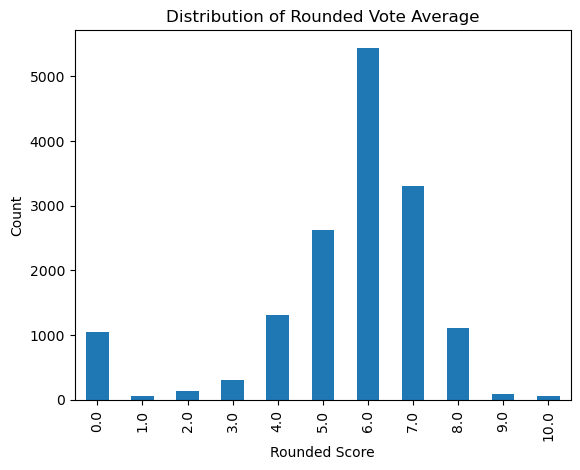

In [7]:
plot_data_counts.plot(kind='bar')
plt.title('Distribution of Rounded Vote Average')
plt.xlabel('Rounded Score')
plt.ylabel('Count')
plt.show()

Make a pie chart with the adult vs non adult movies

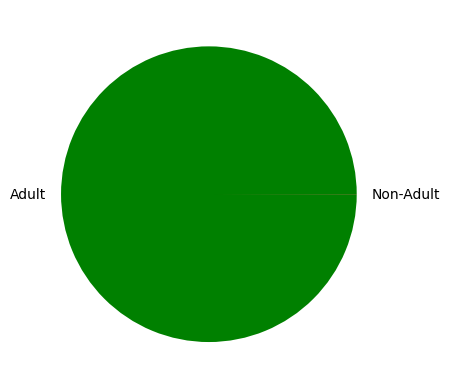

In [8]:
labels = ['Adult','Non-Adult']
plt.pie(df['adult'].value_counts(), colors= ['g','r'],labels=labels)
plt.show()

Gather some useful numbers about runtime

In [9]:
df['runtime'].describe()

count    15394.000000
mean        95.660517
std         41.078450
min          0.000000
25%         87.000000
50%         96.000000
75%        108.000000
max       1140.000000
Name: runtime, dtype: float64

Movies with runtime > 300 min: 42


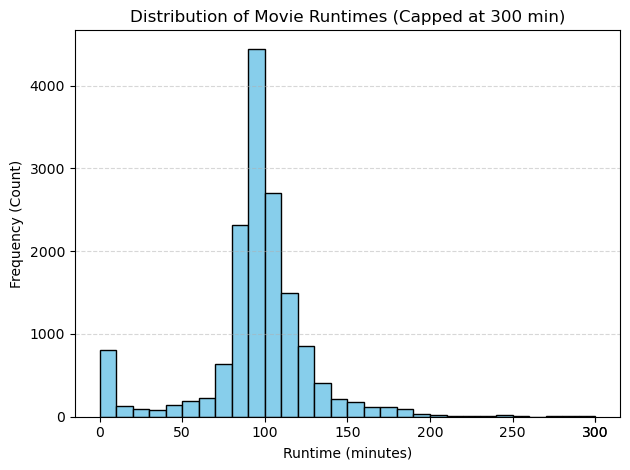

In [10]:
max_view_runtime = 300
bins = np.arange(0, max_view_runtime + 10, 10)

# Plot the histogram, ignoring NaN values (which describe() already did)
df['runtime'].plot(
    kind='hist',
    bins=bins,
    edgecolor='black',
    color='skyblue',
    title='Distribution of Movie Runtimes (Capped at 300 min)'
)

# Label the x-axis, adjusting the last bin label for clarity
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency (Count)')
plt.xticks(np.append(bins[::5], [max_view_runtime])) # Show ticks every 50 min
plt.grid(axis='y', alpha=0.5, linestyle='--')

# You might need to manually label the last bin for runtimes > 300
print(f"Movies with runtime > 300 min: {len(df.loc[df['runtime'] > max_view_runtime])}")

plt.tight_layout()
plt.show()

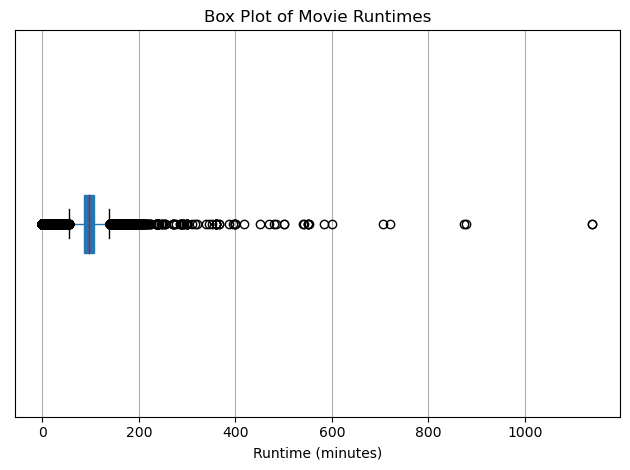

In [11]:
df.boxplot(
    column='runtime',
    vert=False, # Horizontal orientation is often cleaner for single column
    patch_artist=True, # Allows coloring the box
    medianprops=dict(color='red') # Highlights the median line
)

plt.title('Box Plot of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.yticks([]) # Remove the y-axis label for a cleaner look

plt.tight_layout()
plt.show()

Use the classification of VaderSentiment to see the distribution among neutral, positive and negative

In [12]:
def convert_string_to_list(genres_string): 
    if pd.isna(genres_string):
        return [{'name': 'notfound', 'iso_3166_1':'notfound'}]
    
    # Check for None or an empty string, which also signify missing data
    if genres_string is None or genres_string == "":
        return [{'name': 'notfound'}]
    
    return ast.literal_eval(genres_string)

### Preprocessing the cast column by: 

-Extracting the castnames out of the dictionary form into list form <br>
-Importing a dataset found online containing the 50 most known actors around the world <br>
-Looking up into the list of actors per movie if this movie contains one of these actors <br>
-Making a dummy variable: is_top_actor_movie (1 if contains one of the 50 actors, 0 else) <br>

In [13]:
def extract_cast_names(cast_str):
    """
    Safely converts the string representation of a cast list 
    into a Python list and extracts the actor names.
    """
    # 1. Handle non-string/missing data
    if pd.isna(cast_str) or not isinstance(cast_str, str) or cast_str.strip() == '':
        return []
    
    try:
        # 2. Safely convert the string to a list of dictionaries
        cast_list = ast.literal_eval(cast_str)
        
        # 3. Extract the 'name' from each dictionary (list comprehension)
        return [d['name'] for d in cast_list]
    
    except (ValueError, TypeError):
        # 4. Handle any malformed strings
        return []

# Create a new column 'cast_names' by applying the function to the 'cast' column
df['cast_names'] = df['cast'].apply(extract_cast_names)

In [14]:
actors = pd.read_csv(r"C:\Users\elias\Desktop\HIRB\Liege\Data Management\Hollywood actors.csv")
actors

,Name,Date of Birth,Place of Birth,Oscars,Oscar Nominations,BAFTA,BAFTA Nominations,Golden Globes,Golden Globe Nominations,Greatest Performances
0,Al Pacino,25 April 1940,"East Harlem, New York, United States",1,8,2,5,4,15,"Serpico, Scent of a Woman, Dog Day Afternoon, ..."
1,Alan Arkin,26 March 1934,"Brooklyn, New York, United States",1,4,1,3,1,6,"Argo, Little Miss Sunshine, The Heart Is a Lon..."
2,Alan Rickman,21 February 1946,"Hammersmith, London, United Kingdom",0,0,1,4,1,1,"Michael Collins, Truly Madly Deeply, Sense and..."
3,Albert Finney,9 May 1936,"Charlestown, Salford, United Kingdom",0,5,2,13,2,9,"The Murder on the orient Express, The Dresser,..."
4,Alec Guinness,2 April 1914,"Maida Vale, London, United Kingdom",1,5,3,7,1,3,"Star Wars, Little Dorrit, The Bridge on the Ri..."
...,...,...,...,...,...,...,...,...,...,...
95,Tom Hanks,9 July 1956,"Concord, California, United States",2,5,0,4,4,8,"Cast Away, Forrest Gump, Philadelphia, Saving ..."
96,Tommy Lee Jones,15 September 1946,"San Saba, Texas, United States",1,4,0,4,1,4,"In the Valley of Elah, Lincoln, The Fugitive"
97,Will Smith,25 September 1968,"Philadelphia, Pennsylvania, United States",0,2,0,0,0,5,"The Pursuit of Happiness, Ali, Concussion"
98,William Holden,17 April 1918,"O'Fallon, Illinois, United States",1,3,0,2,0,0,"Network, Stalag 17, Sunset Blvd."


In [15]:
top_actors_set = set(actors['Name'].dropna().str.strip())

def check_for_top_actors(cast_names_list):
    """
    Checks if any name in the movie's cast list is present in the top_actors_set.
    """
    if not isinstance(cast_names_list, list):
        return 0 # Handle cases where the list is missing or not a list
        
    for name in cast_names_list:
        # Check if the name (stripped of whitespace) is in the set
        if str(name).strip() in top_actors_set:
            return 1
            
    return 0

df['is_top_actor_movie'] = df['cast_names'].apply(check_for_top_actors)

### Adding in scraped summary and storyline from IMDB

In [16]:
summary_story_line = pd.read_csv(r"C:\Users\elias\Downloads\Data Management\plot_data.csv")

summary_story_line = summary_story_line.drop("Unnamed: 0",axis = 1)
summary_story_line["0"] = summary_story_line["0"].fillna("")
summary_story_line["1"] = summary_story_line["1"].fillna("")
summary_story_line.head()


,0,1
0,A cowboy doll is profoundly jealous when a new...,A little boy named Andy loves to be in his roo...
1,A magic board game summons jungle perils and a...,"Jumanji, one of the most unique--and dangerous..."
2,Just as John and Max resolve to save their bel...,Things don't seem to change much in Wabasha Co...
3,"Based on Terry McMillan's novel, this film fol...",This story based on the best selling novel by ...
4,George Banks must deal not only with his daugh...,"In this sequel to ""Father of the Bride"", Georg..."


In [17]:
# 3. Assign the new columns to the original DataFrame
df['summary'] = summary_story_line["0"]
df['storyline'] = summary_story_line["1"]

### One-hot encoding of the languages

In [18]:
language_dummies = pd.get_dummies(
    df['original_language'], 
    prefix='lang'
)

# 2. Concatenate the new dummy variables back to the original DataFrame
# We use axis=1 to concatenate columns.
df = pd.concat([df, language_dummies], axis=1)
df.drop('original_language', axis=1, inplace=True)

### Sentiment analysis on summary and storyline

-Using the scraped summary and storyline from another notebook <br>
-Based on these texts, get the vader sentiment compound score which will be used as a numeric value in our models.

In [19]:
def get_vader_sentiment(text):
    """Calculates the VADER compound sentiment score."""
    if text is None:
        return None
    
    # Initialize the analyzer inside the function if you prefer it self-contained, 
    # but for performance, it's better to initialize outside the apply() loop.
    # For this example, let's assume it's initialized once outside.
    # ia = SentimentIntensityAnalyzer()
    
    scores = ia.polarity_scores(str(text))
    return scores['compound']

# 1. Initialize the analyzer once
ia = SentimentIntensityAnalyzer()

# 2. Apply the function to your 'storyline' column
# Assuming your DataFrame is 'df' and the storyline column is 'storyline'
df['overview_sentiment_vader'] = df['overview'].apply(get_vader_sentiment)
df['summary_sentiment_vader'] = df['summary'].apply(get_vader_sentiment)
df['storyline_sentiment_vader'] = df['storyline'].apply(get_vader_sentiment)

In [20]:
df['storyline_tone'] = df['storyline_sentiment_vader'].apply(
    lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral')
)

df['summary_tone'] = df['storyline_sentiment_vader'].apply(
    lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral')
)

### One hot encoding of the genres 

-Convert the genres from the string data type to a list data containing dictionaries type to facilitate access <br>
-Extract from the dictionaries the genre names <br>
-Using the MultiLabelBinarizer create a dummy variable for every unique genre <br>

In [21]:
df['genres'] = df['genres'].apply(convert_string_to_list)

In [22]:
def extract_names(genre_list):
    """Extracts only the 'name' strings from the list of dictionaries."""
    names = []
    for i in range(0, len(genre_list)): 
        names.append(genre_list[i]['name'])
    return names

In [23]:
df['genre_names'] = df['genres'].apply(extract_names)

In [24]:

mlb = MultiLabelBinarizer()

# 2. Fit and Transform: This processes the entire Series of lists at once
genre_dummies = pd.DataFrame(
    # .fit_transform expects an iterable of iterables (list of lists in this case)
    mlb.fit_transform(df['genre_names']), 
    # Use the discovered classes (unique genres) as column names
    columns=mlb.classes_, 
    # Use the original DataFrame index for merging
    index=df.index 
)

# 3. Rename columns and merge
genre_dummies = genre_dummies.add_prefix('genre_')
df = pd.concat([df, genre_dummies], axis=1)

### Preprocessing the release date

-By converting the date to a datetime timestamp, to extract the year, month and day of the week

In [25]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year.astype('Int64')
df['release_month'] = df['release_date'].dt.month.astype('Int64')
df['release_dayofweek'] = df['release_date'].dt.dayofweek.astype('Int64')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15489 entries, 0 to 15488
Columns: 139 entries, movieId to release_dayofweek
dtypes: Int64(4), bool(76), datetime64[ns](1), float64(11), int32(20), int64(4), object(23)
memory usage: 7.4+ MB


### Preprocessing the target variable

We will make the shift from a continous target to a binary variable because we simply want to know if it is recommendable or not.
(Do EDA to find optimal threshold)

Recommend will be our target variable

Threshold for recommended movie is rating of 6 --> 1 if rating above 6 else 0

In [27]:
def recommend(vote_average): 
    if vote_average >= 6: 
        return 1
    else: 
        return 0
df['recommend'] = df['vote_average'].apply(recommend)


### Preprocessing production country 

-Extracting the production countries into a list <br>
-Using MultiLableBinarizer to make dummy variables for every unique country

In [28]:
#Check for production countries if this is useful because it might be very imbalanced if alot of US compared to the rest
df['production_countries'] = df['production_countries'].apply(convert_string_to_list)

In [29]:
def extract_iso_name(country_list):
    """Extracts only the 'name' strings from the list of dictionaries."""
    countries = []
    for i in range(0, len(country_list)): 
        countries.append(country_list[i]['iso_3166_1'])
    return countries

In [30]:
df['production_isos'] = df['production_countries'].apply(extract_iso_name)

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# 2. Fit and Transform: This processes the entire Series of lists at once
country_dummies = pd.DataFrame(
    # .fit_transform expects an iterable of iterables (list of lists in this case)
    mlb.fit_transform(df['production_isos']), 
    # Use the discovered classes (unique genres) as column names
    columns=mlb.classes_, 
    # Use the original DataFrame index for merging
    index=df.index 
)

# 3. Rename columns and merge
country_dummies = country_dummies.add_prefix('production_country_')
df = pd.concat([df, country_dummies], axis=1)

### Visualization of the production countries <br>
Do this because hypothesis that the data will be very imbalanced towards USA

To use the plotly Chloropleth visualization we need to ISO country code in 3 letters instead of 2 letters.

In [32]:
def get_3_letter_code(iso_list):
    """
    Takes a list of ISO-A2 codes, returns the continent code of the first
    valid country in the list, or 'UNKNOWN' if none are found.
    """
    three_letters = []
    if not iso_list:
        three_letters.append('UNKNOWN')  # Handle empty lists
    
    # Try to use the first ISO code in the list
    for i in range(0,len(iso_list)):

        try:
            # Get the 2-letter continent code (e.g., 'NA', 'EU', 'AS')
            country = country_alpha2_to_country_name(iso_list[i])

            iso_3 = country_name_to_country_alpha3(country)
            three_letters.append(iso_3)

        except Exception as e:
            # Handle cases where the country code might be invalid or not in the library
            # print(f"Warning: Could not process ISO code {first_iso}. Error: {e}") 
            three_letters.append("UNKNOWN")
            
    return three_letters
    

df['ISO3'] = df['production_isos'].apply(get_3_letter_code)


In [33]:
all_isos = list(chain.from_iterable(df['ISO3']))
country_counts = pd.Series(all_isos).value_counts().reset_index()
country_counts.columns = ['ISO_Code', 'Count']

In [34]:
fig = px.choropleth(
    country_counts, 
    locations='ISO_Code',     
    color='Count',             
    hover_name='ISO_Code',     
    color_continuous_scale=px.colors.sequential.Reds,
    title='World Map of Production Country Counts'
)

# Optional: Adjust the map to focus on the world
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='natural earth' 
    )
)

fig.show()

Because we see indeed that the USA is mostly used as the production country, we will do an aggregation towards continent level. That we will visualize below in order to avoid overfitting for a certain country.

In [35]:
def get_continent_from_isos(iso_list):
    """
    Takes a list of ISO-A2 codes, returns the continent code of the first
    valid country in the list, or 'UNKNOWN' if none are found.
    """
    continents = []
    if not iso_list:
        continents.append('UNKNOWN')  # Handle empty lists
    
    for i in range(0,len(iso_list)):
    
        try:
            # Get the 2-letter continent code (e.g., 'NA', 'EU', 'AS')
            continent = country_alpha2_to_continent_code(iso_list[i])
            continents.append(continent)

        except Exception as e:
            # Handle cases where the country code might be invalid or not in the library
            # print(f"Warning: Could not process ISO code {first_iso}. Error: {e}") 
            continents.append("UNKNOWN")
    return continents


df['continent'] = df['production_isos'].apply(get_continent_from_isos)

In [36]:
all_continents = list(chain.from_iterable(df['continent']))
continent_counts = pd.Series(all_continents).value_counts().reset_index()
continent_counts.columns = ['Continent_Code', 'Count']

We print here how many movies were developed per continent, this also shows that there is sometimes collaboration between North-American moviemakers and European movie makers.

In [37]:
df['continent'].value_counts()

continent
[NA]                                5799
[UNKNOWN]                           2540
[EU]                                2527
[AS]                                1404
[EU, NA]                             576
                                    ... 
[EU, AS, AS, EU, EU]                   1
[EU, EU, AS, EU, EU, EU, NA]           1
[SA, SA, SA, EU, EU, SA, EU, NA]       1
[EU, NA, AS, EU, EU, EU]               1
[AS, EU, UNKNOWN]                      1
Name: count, Length: 213, dtype: int64

In [38]:
mlb = MultiLabelBinarizer()


continent_dummies = pd.DataFrame(
    mlb.fit_transform(df['continent']), 
    columns=mlb.classes_, 
    index=df.index 
)

continent_dummies = continent_dummies.add_prefix('continent_')
df = pd.concat([df, continent_dummies], axis=1)

### Preprocessing production company
-Reading in csv that we made in other notebook containing the production companies ordered by amount of gross profit <br>
-We will only consider for this project the 15 companies with the highest gross profit <br>
-Dummy variable is_top_company_movie is 1 if produced by one of these companies, 0 otherwise

In [39]:
df_companies = pd.read_csv("highest_to_lowest_gross.csv")
df_companies = df_companies.head(15)
df_companies

,company,gross
0,Warner Bros.,58461325565
1,Universal Pictures,54811498771
2,Columbia Pictures,50453311657
3,Walt Disney Pictures,46900185481
4,Marvel Studios,45115906192
5,Paramount Pictures,41041407928
6,20th Century Fox,27388273406
7,Legendary Pictures,19453923001
8,New Line Cinema,19426490440
9,DreamWorks Animation,18550483197


In [40]:
def check_for_top_companies(companies_list):
    """
    Checks if any name in the movie's cast list is present in the top_actors_set.
    """
    if not isinstance(companies_list, list):
        return 0 # Handle cases where the list is missing or not a list
     
    for name in companies_list:
        # Check if the name (stripped of whitespace) is in the set
        
        if str(name['name']).strip() in top_companies_set:
            return 1
            
    return 0

In [41]:
#Cleaning some company names of the dataframe.
df_companies['company'].replace('Disney-Pixar', 'Pixar Animation Studios', inplace=True)

In [42]:
df['production_companies'] = df['production_companies'].apply(convert_string_to_list)

In [43]:
top_companies_set = set(df_companies['company'].dropna().str.strip())
df['is_top_company_movie'] = df['production_companies'].apply(check_for_top_companies)

### Outlier detection on runtime column using IsolationForest + imputation

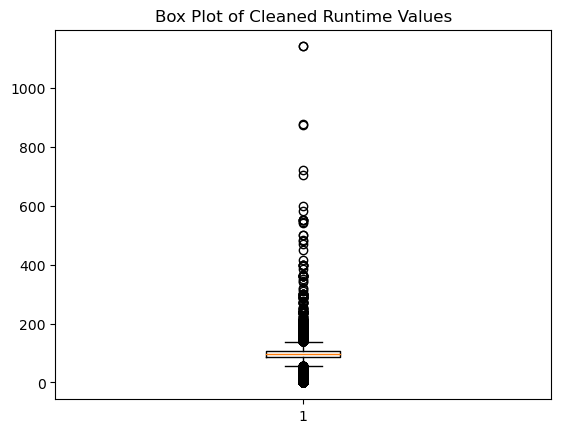

In [44]:
runtime_clean = pd.to_numeric(df['runtime'], errors='coerce').dropna()

plt.boxplot(runtime_clean)
plt.title('Box Plot of Cleaned Runtime Values')
plt.show()

In [45]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.005, random_state=42)
X_clean = runtime_clean.values.reshape(-1, 1)
# Fit the model and predict the anomalies.
# -1 indicates an outlier (anomaly), 1 indicates an inlier (normal).
anomaly_predictions = iso.fit_predict(X_clean)

# --- 4. IDENTIFY AND SEPARATE OUTLIERS ---

# Create a temporary DataFrame from the clean data to easily join predictions
clean_df_temp = runtime_clean.to_frame(name='runtime')
clean_df_temp['anomaly'] = anomaly_predictions

# Identify the outliers (anomaly = -1)
outliers = clean_df_temp[clean_df_temp['anomaly'] == -1]
outliers

,runtime,anomaly
949,287.0,-1
1009,242.0,-1
2159,298.0,-1
2417,254.0,-1
4034,273.0,-1
...,...,...
15054,583.0,-1
15082,292.0,-1
15083,360.0,-1
15119,550.0,-1


In [46]:
avg_runtime = clean_df_temp[clean_df_temp['anomaly'] == 1]['runtime'].mean()
outlier_indices = outliers.index
df.loc[outlier_indices, 'runtime'] = avg_runtime

### Investigating budget column and dropping rows where there is no budget
We want to test the hypothesis if indeed a higher budget leads to higher probability of being recommended

In [53]:
df2 = df[df['budget'] > 0]

### Dropping unnecessary columns

In [54]:
cols_to_drop = ['tmdbId','crew','id_x','tagline','video','homepage','id_y', 'cast','genre_names','genres','overview','summary','storyline','cast_names','revenue','poster_path', 'release_date','popularity',
'vote_average','production_countries','continent','ISO3','belongs_to_collection','tagline','title','movieId','imdbId', 'full_imdbid','original_title','production_companies','spoken_languages','status',
               'imdb_id','vote_count','vote_bin_round','storyline_tone','summary_tone','production_isos']


df_with_budget = df2.drop(cols_to_drop,axis=1)
print(len(df_with_budget))

df_with_budget.to_csv(r'C:\Users\elias\Desktop\HIRB\Liege\Data Management\df_with_budget.csv', index = False)

3856


In [49]:
df_without_budget = df.drop(cols_to_drop, axis = 1)
df_without_budget = df_without_budget.drop("budget",axis = 1)

In [50]:
df_without_budget

,adult,runtime,is_top_actor_movie,lang_ab,lang_af,lang_ar,lang_bg,lang_bm,lang_bn,lang_bo,...,production_country_ZW,production_country_notfound,continent_AF,continent_AS,continent_EU,continent_NA,continent_OC,continent_SA,continent_UNKNOWN,is_top_company_movie
0,False,81.0,1,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,1
1,False,104.0,1,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
2,False,101.0,1,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,1
3,False,127.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
4,False,106.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15484,False,45.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
15485,False,30.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
15486,False,85.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
15487,False,104.0,0,False,False,False,False,False,False,False,...,0,0,0,0,1,1,0,0,0,0


### Save to csv 

In [51]:
df_without_budget.to_csv(r"C:\Users\elias\Desktop\HIRB\Liege\Data Management\df_without_budget.csv", index = False)